In [2]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm
import os
import xgboost as xgb
import sklearn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression

import cv2
%matplotlib inline
sns.set_style("dark")
import warnings
warnings.filterwarnings('ignore')

In [3]:
def load_image_data(folder_benign='../data/resized/benign', folder_malignant='../data/resized/malignant'):
    ims_benign = np.array([cv2.imread(os.path.join(folder_benign, filename)) for filename in os.listdir(folder_benign)])
    ims_malignant = np.array([cv2.imread(os.path.join(folder_malignant, filename)) for filename in os.listdir(folder_malignant)])
    print(f"Benign images vector shape: {ims_benign.shape}")
    print(f"Malignant images vector shape: {ims_malignant.shape}")
    return ims_benign, ims_malignant

In [4]:
def flatten_image_vectors_and_generate_labels(ims_benign, ims_malignant):
    X_benign = ims_benign.flatten().reshape(ims_benign.shape[0], ims_benign.shape[1] * ims_benign.shape[2] * ims_benign.shape[3])
    X_malinant = ims_malignant.flatten().reshape(ims_malignant.shape[0], ims_malignant.shape[1] * ims_malignant.shape[2] * ims_malignant.shape[3])
    return X_benign, X_malinant

In [5]:
def get_test_train_data(X_benign, X_malinant, seed, scaled=True):
    X_train_benign, X_test_benign, Y_train_benign, Y_test_benign = train_test_split(X_benign, np.zeros(X_benign.shape[0]), test_size=0.1, random_state=seed)
    X_train_malinant, X_test_malinant, Y_train_malinant, Y_test_malinant = train_test_split(X_malinant, np.ones(X_malinant.shape[0]), test_size=0.1, random_state=seed)
    X_train = np.concatenate((X_train_benign, X_train_malinant), axis=0)
    Y_train = np.concatenate((Y_train_benign, Y_train_malinant), axis=0)
    X_test = np.concatenate((X_test_benign, X_test_malinant), axis=0)
    Y_test = np.concatenate((Y_test_benign, Y_test_malinant), axis=0)
    if scaled:
        scaler = StandardScaler().fit(X_train)
        X_train_scaled = scaler.transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        return X_train_scaled, X_test_scaled, Y_train, Y_test
    return (X_train, X_test, Y_train, Y_test)

In [89]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Oranges, names=['benign', 'malignant']):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [125]:
def plot_roc_auc(Y_test, probs, title='Receiver operating characteristic (Holdout set)'):
    fpr, tpr, _ = roc_curve(Y_test, probs)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([-0.02, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

In [29]:
seed=42
ims_benign, ims_malignant = load_image_data('../data/resized_600_450/benign', '../data/resized_600_450/malignant/')
X_benign,X_malinant = flatten_image_vectors_and_generate_labels(ims_benign=ims_benign, ims_malignant=ims_malignant)
X = np.concatenate((X_benign, X_malinant), axis=0)
Y = np.concatenate((np.zeros(X_benign.shape[0]), np.ones(X_malinant.shape[0])))
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)
pca = PCA(.998)
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)

Benign images vector shape: (150, 450, 600, 3)
Malignant images vector shape: (150, 450, 600, 3)


In [207]:
X_pca.shape

(300, 263)

In [64]:
X_train, X_test, Y_train, Y_test = train_test_split(X_pca, Y, test_size=0.2, random_state=42)

In [65]:
seed = 42
num_trees=150
models = {
     'SVM' : svm.SVC(random_state=42, gamma='scale'),
     'LDA' : LinearDiscriminantAnalysis(),
     'XGBoost' : xgb.XGBClassifier(),
     'RF': RandomForestClassifier(n_estimators=num_trees, random_state=seed),
     'LR':LogisticRegression(solver='lbfgs', max_iter=1000)
 }

Model:SVM --> Mean:[0.5866666666666667] , STD:[0.11274356350191841]
Model:LDA --> Mean:[0.52] , STD:[0.0805536398239638]
Model:XGBoost --> Mean:[0.5933333333333333] , STD:[0.11333333333333334]
Model:RF --> Mean:[0.6233333333333334] , STD:[0.0683942817622773]
Model:LR --> Mean:[0.5599999999999999] , STD:[0.08793937305515277]


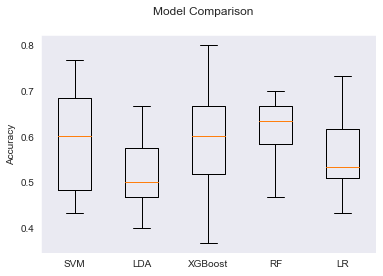

In [147]:
results = []
names =[]
for name, model in models.items():
    cv_results = cross_val_score(model, X_pca, Y, cv=KFold(n_splits=10), scoring="accuracy", n_jobs=-1)
    print(f"Model:{name} --> Mean:[{cv_results.mean()}] , STD:[{cv_results.std()}]")
    names.append(name)
    results.append(cv_results)
fig = plt.figure()
fig.suptitle(f'Model Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.ylabel("Accuracy")
plt.show()

In [71]:
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf', 'linear', 'poly']}
grid = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 3, cv=KFold(n_splits=10), n_jobs=5, scoring="accuracy")   
grid.fit(X_train, Y_train)

Fitting 10 folds for each of 75 candidates, totalling 750 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    2.6s
[Parallel(n_jobs=5)]: Done 564 tasks      | elapsed:    6.6s
[Parallel(n_jobs=5)]: Done 741 out of 750 | elapsed:    8.0s remaining:    0.1s
[Parallel(n_jobs=5)]: Done 750 out of 750 | elapsed:    8.0s finished


GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
             error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=5,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'linear', 'poly']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=3)

In [178]:
grid.best_params_

{'C': 0.1, 'gamma': 1, 'kernel': 'poly'}

In [72]:
accuracy_score(Y_test, grid.best_estimator_.predict(X_test))

0.7

In [180]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, grid.predict(X_test), target_names=['benign', 'malignant']))

              precision    recall  f1-score   support

      benign       0.67      0.76      0.71        29
   malignant       0.74      0.65      0.69        31

    accuracy                           0.70        60
   macro avg       0.70      0.70      0.70        60
weighted avg       0.70      0.70      0.70        60



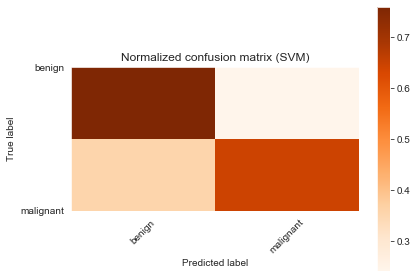

In [92]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, grid.predict(X_test))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
# print('Normalized confusion matrix')
# print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix (SVM)')
plt.show()

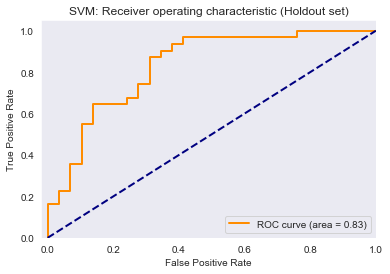

In [181]:
plot_roc_auc(Y_test,grid.decision_function(X_test), 'SVM: Receiver operating characteristic (Holdout set)')

In [187]:
params= {
    'n_estimators' : list(range(10,500,10)),
    'max_features' : list(range(6,32,5))
}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=seed), params, refit=True, cv=KFold(n_splits=10), verbose=3,scoring="accuracy", n_jobs=5)
rf_grid.fit(X_train, Y_train)

Fitting 10 folds for each of 294 candidates, totalling 2940 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 201 tasks      | elapsed:   14.4s
[Parallel(n_jobs=5)]: Done 368 tasks      | elapsed:   43.3s
[Parallel(n_jobs=5)]: Done 592 tasks      | elapsed:  1.3min
[Parallel(n_jobs=5)]: Done 880 tasks      | elapsed:  2.3min
[Parallel(n_jobs=5)]: Done 1232 tasks      | elapsed:  3.3min
[Parallel(n_jobs=5)]: Done 1648 tasks      | elapsed:  4.7min
[Parallel(n_jobs=5)]: Done 2128 tasks      | elapsed:  6.5min
[Parallel(n_jobs=5)]: Done 2672 tasks      | elapsed:  8.7min
[Parallel(n_jobs=5)]: Done 2940 out of 2940 | elapsed: 10.4min finished


GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
             error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf...
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False, random_state=42,
                                              verbose=0, warm_start=False),
  

In [188]:
rf_grid.best_params_

{'max_features': 16, 'n_estimators': 420}

In [189]:
accuracy_score(Y_test, rf_grid.best_estimator_.predict(X_test))

0.7333333333333333

In [191]:
print(classification_report(Y_test, rf_grid.predict(X_test), target_names=['benign', 'malignant']))

              precision    recall  f1-score   support

      benign       0.76      0.66      0.70        29
   malignant       0.71      0.81      0.76        31

    accuracy                           0.73        60
   macro avg       0.74      0.73      0.73        60
weighted avg       0.74      0.73      0.73        60



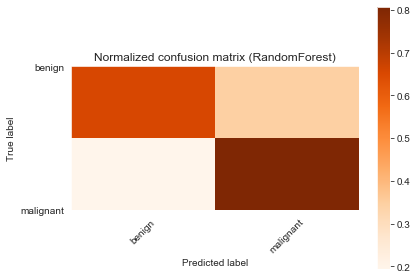

In [192]:
cm = confusion_matrix(Y_test, rf_grid.predict(X_test))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix (RandomForest)')
plt.show()

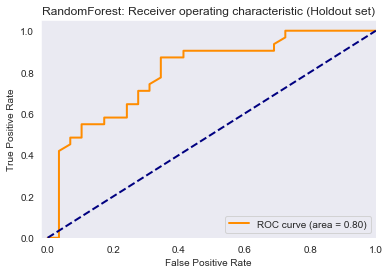

In [198]:
plot_roc_auc(Y_test,rf_grid.predict_proba(X_test)[:,1], 'RandomForest: Receiver operating characteristic (Holdout set)')

In [199]:
params = {
    'shrinkage' : np.arange(0, 1.1, 0.1)
}
lda_grid =  GridSearchCV(LinearDiscriminantAnalysis(solver='lsqr'), params, refit=True, cv=KFold(n_splits=10), verbose=3,scoring="accuracy", n_jobs=5)
lda_grid.fit(X_train, Y_train)

Fitting 10 folds for each of 11 candidates, totalling 110 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 110 out of 110 | elapsed:    2.5s finished


GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
             error_score='raise-deprecating',
             estimator=LinearDiscriminantAnalysis(n_components=None,
                                                  priors=None, shrinkage=None,
                                                  solver='lsqr',
                                                  store_covariance=False,
                                                  tol=0.0001),
             iid='warn', n_jobs=5,
             param_grid={'shrinkage': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=3)

In [200]:
lda_grid.best_params_

{'shrinkage': 0.9}

In [202]:
print(classification_report(Y_test, lda_grid.predict(X_test), target_names=['benign', 'malignant']))

              precision    recall  f1-score   support

      benign       0.64      0.79      0.71        29
   malignant       0.75      0.58      0.65        31

    accuracy                           0.68        60
   macro avg       0.69      0.69      0.68        60
weighted avg       0.70      0.68      0.68        60



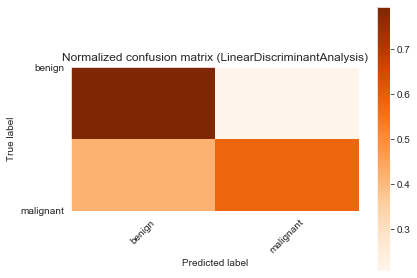

In [203]:
cm = confusion_matrix(Y_test, lda_grid.predict(X_test))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix (LinearDiscriminantAnalysis)')
plt.show()

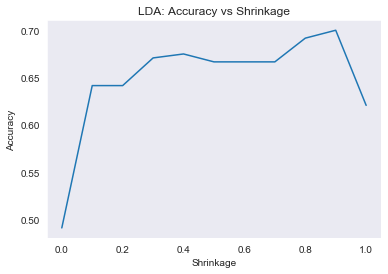

In [206]:
df = pd.DataFrame(lda_grid.cv_results_)
plt.plot(params['shrinkage'], df['mean_test_score'])
plt.title("LDA: Accuracy vs Shrinkage")
plt.xlabel("Shrinkage")
plt.ylabel("Accuracy")
plt.show()

In [177]:
accuracy_score(Y_test, lda_grid.best_estimator_.predict(X_test))

0.6833333333333333

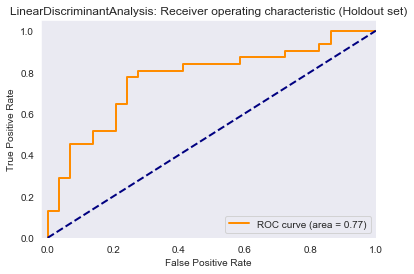

In [205]:
plot_roc_auc(Y_test,lda_grid.predict_proba(X_test)[:,1], 'LinearDiscriminantAnalysis: Receiver operating characteristic (Holdout set)')